 Poetry Generation

Zach O'Brien

December 2022




In [1]:
import itertools
import pickle
import random
random.seed(1)  # To make results reproducible
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress tensorflow debugging info

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.util import pad_sequence
from nltk.lm.preprocessing import flatten

from dataprep.parse_leaves_of_grass import leaves_of_grass_gutenberg_to_df
from dataprep.ngram_lm_dataprep import preprocess_for_ngram_lm, postprocess_for_ngram_lm
from models.ngram_language_model import LanguageModel

---

## 1. Data Preparation

The raw data I used for this project was the complete text of Walt Whitman's "Leaves of Grass". To use it with NLP models, I had to parse out individual poems from the collection and then do some preprocessing on them.

### 1.1 Parse Raw Document

(See my source code `dataprep/` directory for implementation details on data preparation)

In [2]:
with open("data/leaves-of-grass.txt") as f:
    lines = f.readlines()

# I encapsulated the functionality of parsing the raw text into this function.
# It essentially segments on books, then poems.
poems = leaves_of_grass_gutenberg_to_df(lines)
poems.to_csv("data/leaves_of_grass.csv")
poems.head(2)

,book_title,poem_title,poem
0,BOOK I. INSCRIPTIONS,One’s-Self I Sing,"One’s-self I sing, a simple separate person,\n..."
1,BOOK I. INSCRIPTIONS,As I Ponder’d in Silence,"As I ponder’d in silence,\n Returning upon my..."


In [3]:
poems["poem"][0]

'One’s-self I sing, a simple separate person,\n  Yet utter the word Democratic, the word En-Masse.\n\n  Of physiology from top to toe I sing,\n  Not physiognomy alone nor brain alone is worthy for the Muse, I say\n      the Form complete is worthier far,\n  The Female equally with the Male I sing.\n\n  Of Life immense in passion, pulse, and power,\n  Cheerful, for freest action form’d under the laws divine,\n  The Modern Man I sing.'

---

## 2. 2-gram and 3-gram Language Models

For this model I did not use a library. I used my own implementation of an n-gram language model from earlier inthe semester.

### 2.1 Prepare n-grams to give to the model

In [4]:
# To indicate the beginning and end of a poem
POEM_START_SYMBOL = "<p>"
POEM_END_SYMBOL = "</p>"

In [5]:
# Tokenize poems into words, but not sentences. Sentence and line breaks
# can have artistic meaning in poems, so I want their relationships to actual words
# to be preserved.
def create_tokens_for_ngram(poems, n):
    """Create tokens for an n-gram language model
    
    Parameters:
        poems (list[str]): List of poems
        n (int): The size of each n-gram
    
    Returns:
        tokens (list[str]): List of tokens
    """
    tokenized_poems = [preprocess_for_ngram_lm(p) for p in poems]
    padded_tokenized_poems = [list(pad_sequence(
                                    poem,
                                    pad_left=True, 
                                    left_pad_symbol=POEM_START_SYMBOL,
                                    pad_right=True,
                                    right_pad_symbol=POEM_END_SYMBOL,
                                    n=n))
                              for poem in tokenized_poems]
    return list(flatten(padded_tokenized_poems))

In [6]:
bigram_tokens = create_tokens_for_ngram(poems["poem"], 2)
trigram_tokens = create_tokens_for_ngram(poems["poem"], 3)

### 2.2 Train the n-gram language model

In [7]:
bigram_model = LanguageModel(2, is_laplace_smoothing=True, replacement_threshold=2)
bigram_model.train(bigram_tokens)

trigram_model = LanguageModel(3, is_laplace_smoothing=True, replacement_threshold=2)
trigram_model.train(trigram_tokens)

### 2.3 Generate a Poem with the 2-gram language model

In [8]:
bigram_poem = bigram_model.generate_poem(max_words=50)
print(postprocess_for_ngram_lm(bigram_poem))

to repel them , i will perhaps to them , sting me does not call of the interior command to me ! drums ! 
 in my way is always sex , 
 consort to me become my words.

 no grain from the day among men together , whispering


In [9]:
trigram_poem = trigram_model.generate_poem(max_words=50)
print(postprocess_for_ngram_lm(trigram_poem))

after the rain , and
 light and of the endless pride and joy , in the air.

 again gurgles the mouth or bosom , hips , leaping , reclining , interrogating ? why myself and comrades found and accepted from every point of the youngest was cut off ,


---

## 3. LSTM Neural Network Language Model

The task of generating text can be framed as a timeseries task. Given a sequence of prior tokens, predict the probability distribution over the vocabulary of the next token in the sequence.

In this project, I tokenize the data into *characters*, which at first was very counterintuitive to me. During office hours, Professor Amir explained to me why this approach is viable. He also sent me a great article on this task, which can be found here: http://karpathy.github.io/2015/05/21/rnn-effectiveness/.

Here is an overview of how I implemented the data preprocessing and model architecture for this section:

**Preprocessing**

1. Lowercase every poem

2. Wrap each poem in `poem_start` and `poem_end` symbols. Here I used "@" and "$", respectively.

3. Split each poem into characters

4. Replace digits with whitespace to reduce the size of the vocabulary. Numbers are used periodically to mark lines in poems, and I do not want to keep them.

5. Fit a text vectorizer to the vocabulary of character tokens, and vectorize every token

**Model Architecture**

I used a Keras sequential model with two LSTM layers, two Dropout layers, and a softmax output layer:

Input --> LSTM(256) --> Dropout --> LSTM(256) --> Dropout --> Output(Softmax)

**Model Training**

This model is fairly involved to train. There are approximately 1.5 million input samples which are all given to the model every epoch. On a machine without a GPU, training takes hours. I trained on an AWS GPU instance, and saved/loaded the trained model for visualizations and analysis here.

In [10]:
import keras
from keras.utils import timeseries_dataset_from_array
from keras.layers import LSTM, Dropout

from dataprep.neural_lm_dataprep import (
    Vectorizer,
    preprocess_for_neural_lm,
    postprocess_for_neural_lm
)
from models.neural_language_models import build_character_lstm_model

### 3.1 Prepare data

In [11]:
# Load the poems from disk
leaves_of_grass_df = pd.read_csv("data/leaves_of_grass.csv")

leaves_of_grass_df.head(2)

,Unnamed: 0,book_title,poem_title,poem
0,0,BOOK I. INSCRIPTIONS,One’s-Self I Sing,"One’s-self I sing, a simple separate person,\n..."
1,1,BOOK I. INSCRIPTIONS,As I Ponder’d in Silence,"As I ponder’d in silence,\n Returning upon my..."


In [12]:
# Pull only the poems out of the dataset
poems = list(leaves_of_grass_df["poem"])
print("Snippet of original poems:")
print(poems[0][:17])
print()

# Preprocess the poems with the steps outlined above
poems = [preprocess_for_neural_lm(poem) for poem in poems]
print("Snippet after preprocessing:")
print(poems[0][:17], "...")

Snippet of original poems:
One’s-self I sing

Snippet after preprocessing:
['@', 'o', 'n', 'e', '’', 's', '-', 's', 'e', 'l', 'f', ' ', 'i', ' ', 's', 'i', 'n'] ...


In [13]:
# Fit a vectorizer to the vocabulary of characters
vectorizer = Vectorizer()
vectorizer.fit(itertools.chain(*poems))
# Vectorize all characters
vectorized_poems = [vectorizer.tokens_to_vectors(poem) for poem in poems]

with open("artifacts/final_model/vectorizer.pkl", "wb") as outfile:
    pickle.dump(vectorizer, outfile)
    
print("Vocabulary:")
print(vectorizer.vocabulary())

Vocabulary:
['@', 'o', 'n', 'e', '’', 's', '-', 'l', 'f', ' ', 'i', 'g', ',', 'a', 'm', 'p', 'r', 't', '\n', 'y', 'u', 'h', 'w', 'd', 'c', '.', 'b', 'q', 'v', '$', 'k', '?', '(', ')', 'x', 'j', 'z', '!', ';', 'œ', ':', '“', '”', '[', ']']


### 3.2 Create train, validation, and test sets

In [14]:
# Randomly shuffle the poems before splitting into training and validation sets
# Note that random has been given a seed so that the results of the project are reproducible
random.shuffle(vectorized_poems)

In [15]:
# ----- PICK SIZES FOR TRAIN, VALIDATION, TEST DATASETS -----
# Use 70% of the poems for training, 15% for validation 
# during testing, and 15% for final model evaluation.
# IMPORTANT: I first split entire *poems* into training, test,
#            and evaluation. I don't want half of a poem to be in one
#            set and the other half to be in another
train_set_size = int(0.7 * len(vectorized_poems))
validation_set_size = int(0.15 * len(vectorized_poems))
test_set_size = int(0.15 * len(vectorized_poems))

# ----- SLICE OUT THE TRAINING SET -----
train_set = vectorized_poems[:train_set_size]
train_set = np.array(list(itertools.chain(*train_set)))
print(f"# characters in train set:       {len(train_set)}")

# ----- SLICE OUT THE VALIDATION SET -----
validation_set = vectorized_poems[train_set_size:(train_set_size + validation_set_size)]
validation_set = np.array(list(itertools.chain(*validation_set)))
print(f"# characters in validation set:  {len(validation_set)}")

# ----- SLICE OUT THE TEST SET -----
test_set = vectorized_poems[train_set_size+validation_set_size:]
test_set = np.array(list(itertools.chain(*test_set)))
print(f"# characters in test set:        {len(test_set)}")

# Each sample given to the model for training will be a sequence of 100 characters
SEQUENCE_LENGTH = 100
# I do not want to skip any samples, so sampling rate is 1
SAMPLING_RATE = 1
BATCH_SIZE = 4096

print("Building train dataset...")
# Build timeseries datasets using Keras helpers
train_dataset = timeseries_dataset_from_array(
    data=train_set[:-SEQUENCE_LENGTH],
    targets=train_set[SEQUENCE_LENGTH:],
    sampling_rate=SAMPLING_RATE,
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE)
train_dataset.save(path="data/training_dataset_tensorflow/", compression="GZIP")

print("Building validation dataset...")
validation_dataset = timeseries_dataset_from_array(
    data=validation_set[:-SEQUENCE_LENGTH],
    targets=validation_set[SEQUENCE_LENGTH:],
    sampling_rate=SAMPLING_RATE,
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE)
validation_dataset.save(path="data/validation_dataset_tensorflow/", compression="GZIP")

print("Building test dataset...")
testing_dataset = timeseries_dataset_from_array(
    data=test_set[:-SEQUENCE_LENGTH],
    targets=test_set[SEQUENCE_LENGTH:],
    sampling_rate=SAMPLING_RATE,
    sequence_length=SEQUENCE_LENGTH,
    batch_size=BATCH_SIZE)
testing_dataset.save(path="data/testing_dataset_tensorflow/", compression="GZIP")

# characters in train set:       492050
# characters in validation set:  115998
# characters in test set:        117738
Building train dataset...
Building validation dataset...
Building test dataset...


### 3.3 Build and train the model

In [16]:
# Build the model, with LSTM layers for handling the timeseries data
# and Dropout layers to help reduce overfitting
model = build_character_lstm_model(
    vocab_size=vectorizer.vocab_size(),
    hidden_layers=[LSTM(256, return_sequences=True),
                   Dropout(0.3),
                   LSTM(256),
                   Dropout(0.3)],
    lr=0.01)

In [17]:
# Train the model

"""
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset)

model.save("final_model/character_based_lm")  # Save in TensorFlow's new SavedModel format
with open("final_model/history.pkl", "wb") as outfile:
    pickle.dump(history.history, outfile)
"""
print()

Training takes too long on a computer without a GPU, so it is commented out in the final submission.
I trained a model on an AWS GPU server, and have saved the training results to disk.
The model can be found in the `final_model/` directory in my submission, and it is used in the following cells.

### 3.4 Visualize training

In [18]:
MODEL_DIR = "artifacts/final_model/"
HISTORY_PATH = MODEL_DIR + "history.pkl"
MODEL_PATH = MODEL_DIR + "character_based_lm"
VECTORIZER_PATH =  MODEL_DIR + "vectorizer.pkl"

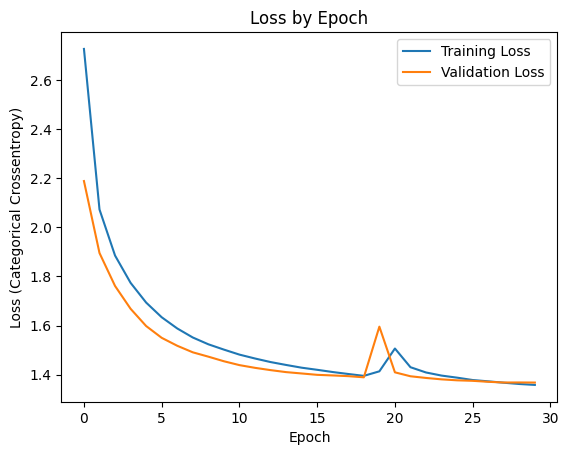

In [19]:
with open(HISTORY_PATH, "rb") as infile:
    history = pickle.load(infile)

fig, ax = plt.subplots()
ax.plot(history["loss"], label="Training Loss")
ax.plot(history["val_loss"], label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (Categorical Crossentropy)")
ax.set_title("Loss by Epoch")
ax.legend()
plt.show()

In [20]:
lstm_model = keras.models.load_model(MODEL_PATH)
print("loaded model")

with open(VECTORIZER_PATH, "rb") as infile:
    vectorizer = pickle.load(infile)
print("loaded vectorizer")

loaded model
loaded vectorizer


### 3.5 Evaluate the model with per-class accuracy

In [21]:
# Instantiate dictionaries to keep track of errors
num_correct_by_idx = {k:0 for k in vectorizer.int_to_token_mapping.keys()}
total_count_by_idx = {k:0 for k in vectorizer.int_to_token_mapping.keys()}

# Iterate over the batches in the testing data, and count
# how many predictions are correctly made
for batch_samples, batch_labels in testing_dataset:
    gold_labels = batch_labels.numpy().argmax(axis=1)
    predictions = lstm_model(batch_samples).numpy().argmax(axis=1)
    for i in range(len(gold_labels)):
        label = gold_labels[i]
        total_count_by_idx[label] += 1
        # If the model prediction is correct, count it
        if label == predictions[i]:
            num_correct_by_idx[label] += 1

# Compute how many predictions of each character were actually correct           
pct_correct_by_idx = {
    idx:(num_correct_by_idx[idx]/total_count_by_idx[idx])
    for idx in num_correct_by_idx.keys()
    if total_count_by_idx[idx] != 0
}

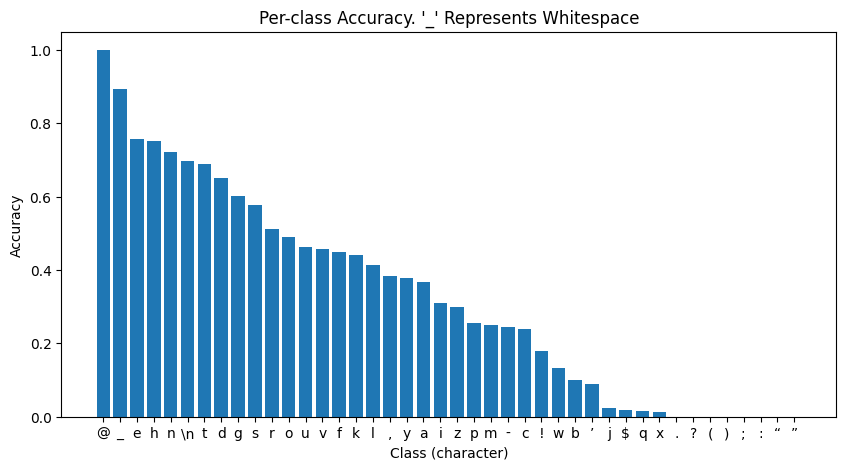

In [22]:
# Compute how many predictions of each character were actually correct    
pct_correct_by_char = {
    vectorizer.int_to_token(i):pct for i,pct in pct_correct_by_idx.items()
}

labels = list(sorted(pct_correct_by_char, key=pct_correct_by_char.get, reverse=True))
pct_correct = [pct_correct_by_char[char] for char in labels]
labels[labels.index(" ")] = "_"
labels[labels.index("\n")] = "\\n"

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(labels, pct_correct)
ax.set_title("Per-class Accuracy. '_' Represents Whitespace")
ax.set_xlabel("Class (character)")
ax.set_ylabel("Accuracy")

plt.show()


### 3.6 Generate a poem

In [23]:
def generate_poem(model, seed, vectorizer, max_length):
    """Generate a poem using a LSTM neural language model
    
    Parameters:
        model (keras.Sequential):
            Trained LSTM neural network
        seed (str):
            The beginning of a poem, to get the model started
        vectorizer (Vectorizer):
            Vectorizer fit to the vocabulary of the model and seed
        max_length (int):
            Maximum number of characters in the poem
    
    Returns:
        str: A poem
    """
    seed_chars = list(seed)
    for i in range(0, max_length):
        # Vectorize the seed phrase and give it the shape:
        # (batch_size, seq_length, vocab_size)
        vec = (vectorizer
               .tokens_to_vectors(seed_chars)
               .reshape(1, len(seed_chars), vectorizer.vocab_size()))

        # Ask the model for a prediction on the current seed phrase
        pred_distribution = model(vec)[0].numpy()

        # Make a choice over the probability distribution, like in the Shannon method
        options = list(range(0, vectorizer.vocab_size()))
        idx = np.random.choice(options, p=pred_distribution)

        # Turn the chosen value into a character and append it to the seed
        char = vectorizer.int_to_token(idx)
        seed_chars.append(char)

        # If the character is one of the poem segmenting symbols, end early
        if char in ["@", "$"]:
            break
    return "".join(seed_chars)


---

## 4. Comparing Generated Poems from N-gram LM and Recurrent Neural LM

Generate 3 poems from each type of model and conduct a qualitative analysis on their differences

#### N-Gram Language Model Poems

In [24]:
# Create poems from BIGRAM model
bigram_lm_poems = [
    postprocess_for_ngram_lm(bigram_model.generate_poem(max_words=100))
    for _ in range(3)
]

# Create poems from TRIGRAM model
trigram_lm_poems = [
    postprocess_for_ngram_lm(trigram_model.generate_poem(max_words=100))
    for _ in range(3)
]

In [25]:
print("----- BIGRAM POEMS -----")
for i, bigram_lm_poem in enumerate(bigram_lm_poems):
    print(f"Poem {i+1}")
    print(bigram_lm_poem)
    print()

print("----- TRIGRAM POEMS -----")
for i, trigram_lm_poem in enumerate(trigram_lm_poems):
    print(f"Poem {i+1}")
    print(trigram_lm_poem)
    print()

----- BIGRAM POEMS -----
Poem 1
a generation playing its myriad waves of proof of the north , 
 by axes ? 
 are , 
 to himself , dress with my arms i hear walt whitman ? is little breaths , 
 i have the neighboring shore to have loved ! 
 torches shine the paths and eidolons.

 and elude the younger by under her she looks back most to thee , 
 soon shall be happy with the states , but one of that makes minute , 
 but the drummers , to merge in bays , i

Poem 2
wandering at table , 
 the buildings and evil propels me seek ’ d all the crew of these chants each and strong divine woman that
 from it is , themselves so that long roll alarming , and
 growth of the way through the male and on my son to call even we wander ’ d scum , 
 my chair by luck veering , more .

Poem 3
1
 what wants , large , the ’ s bay , -- what do less immortal even when the fields of which i heard over the air , full of his brothers mine , , , you hastily walk ’ en at daybreak , thy ultimate human race.

 9
 i have

#### LSTM Language Model Poems

In [26]:
# Create poems from LSTM NEURAL model
seed_phrases = [
    "i sing a song of myself ", 
    "cool afternoon breeze ", 
]
neural_lm_poems = [
    postprocess_for_neural_lm(generate_poem(lstm_model, s, vectorizer, max_length=200))
    for s in seed_phrases
] 

In [27]:
print("----- LSTM POEMS -----")
for i, lstm_lm_poem in enumerate(neural_lm_poems):
    print(f"Poem {i+1}")
    print(lstm_lm_poem)
    print()

----- LSTM POEMS -----
Poem 1
i sing a song of myself in itself,
 to walk-sion vines of holls scorlings, fast, all sweet, for dream,
 the young past and bold, yet it tears. o the songs, or no earth,
 in sponks in these root and fisherous emigran timie

Poem 2
cool afternoon breeze for you,
 see the looking--the value of music, exhibited refire’d,
 which flowering touch--red pork, centre of invitation,
 are the cries when we will shoot rear’d audy as if shapes, the fearless,



### 4.1 Discussion

Unsurprisingly, the bigram model is noticeably worse than the trigram and LSTM models. None of the three models achieve global coherency (coherency through an entire poem), though the trigram and LSTM models have relatively good grammar and create locally coherent/believable snippets.
